import packages

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import warnings

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium

# adding 'custom script' 
#Ensure the [Pyeto](https://github.com/woodcrafty/PyETo) package is present in your 
# "C:\Users\{USERNAME}\anaconda3\envs\{ENVIRONMENT}\Lib\",or "C:\Users\{USERNAME}\anaconda3\Lib\",
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

from scipy.optimize import root

warnings.simplefilter('ignore')

add some useful paths to navigate shared storage:

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

add some spatial data

In [3]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

gdf_discharge_client = gpd.read_file('discharge_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client['name'] = gdf_discharge_client.apply(lambda x: x['name'].split(",")[-1][:-4].strip().lower(),axis=1)

# make general:

#### load precipitation data from analysis

In [4]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall_new.xlsx",index_col=0)
Rainfall_BF_msum.columns

Index(['Black_Volta', 'Lake_Volta', 'Mouhoun', 'Nakambe', 'Oti', 'Penjari'], dtype='object')

In [5]:
Rainfall_BF_msum.head()

,Black_Volta,Lake_Volta,Mouhoun,Nakambe,Oti,Penjari
Date,,,,,,
1979-01-31,0.07,22.16,0.00,0.00,2.11,0.00
1979-02-28,0.19,8.30,0.00,0.00,0.12,0.00
1979-03-31,34.61,112.79,16.96,1.08,67.49,21.70
1979-04-30,67.99,91.50,6.50,1.10,108.33,30.42
1979-05-31,153.06,220.44,106.28,36.68,138.56,81.21


#### load discharge data from analysis

In [6]:
names = ['black volta, vonkoro',
         'bougouriba, dan',
         'mou houn, black volta, samandeni',
         'mou houn, black volta,dapola',
         'nakanbe, white volta, yakala',
         'nakanbe, white volta, yilou',
         'nazinon, red volta, dakaye',
         'pendjari, porga',
         'singou, samboali']

need a dictionary to link discharge to precipitation stations

In [7]:
q_p_linking_dictionary = {'black volta, vonkoro': 'Black_Volta',
                          'bougouriba, dan': 'Mouhoun',
                          'mou houn, black volta, samandeni': 'Mouhoun',
                          'mou houn, black volta,dapola': 'Black_Volta',
                          'nakanbe, white volta, yakala': 'Nakambe',
                          'nakanbe, white volta, yilou': 'Nakambe',
                          'nazinon, red volta, dakaye': 'Nakambe',
                          'pendjari, porga': 'Penjari',
                          'singou, samboali': 'Penjari'}

In [8]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

## Q

In [9]:
df_discharge_lst = []
for index, df in enumerate(df_discharge_per_location_lst):
    name = names[index]
    df_discharge_location = df_discharge_per_location_lst[index].rename(columns={name:"Q"})
    # get month with data
    months_with_data = df_discharge_location.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1).unique()
    
    # get monthly sum
    df_discharge = df_discharge_location.resample('M').sum()
    
    # do indexing magic to discard non-data-eyars
    df_discharge['timestamp'] = df_discharge.apply(lambda x: x.name, axis=1)
    df_discharge.index = df_discharge.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1)
    df_discharge = df_discharge.loc[months_with_data]
    df_discharge.index = df_discharge['timestamp']
    df_discharge.drop(columns="timestamp",inplace=True)
    df_discharge.Q = df_discharge.apply(lambda x: x.Q * x.name.days_in_month * 24 * 3600 , axis=1)
    df_discharge_lst.append(df_discharge)


## E

historic temperature data downloaded from [CMIP6](https://storage.googleapis.com/cmip6/pangeo-cmip6.json) model from NOAA-GFDL - 

In [10]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\daily_Near-Surface-Air-Temperature.xlsx",
# df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                       index_col=0, parse_dates=True)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
df_temperature_msum = df_temperature.resample('M').mean()

In [20]:
df_used_temp = df_temperature.loc[df_temperature.index.year > 1981]

In [65]:
lst_temps = []
months = []
for i in range(1,12+1):
    lst_temps.append(df_used_temp[df_used_temp.index.month==i].mean().Temperature)
    months.append(i)
df = pd.DataFrame(data=zip(months,lst_temps), columns=["months","Temperature"])

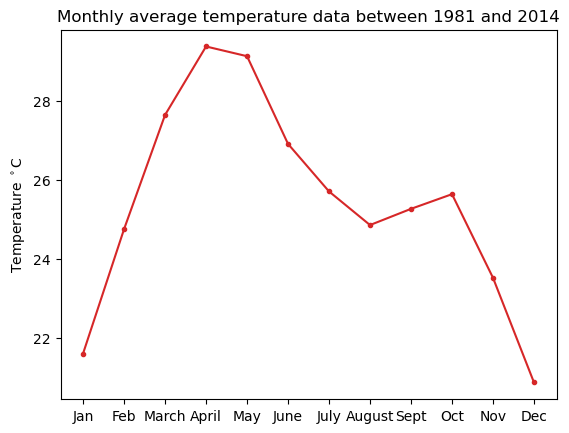

In [67]:
fig, ax = plt.subplots(1)

ax.plot(df.months,df.Temperature,marker=".",color="C3")
ax.set_title("Monthly average temperature data between 1981 and 2014")
ax.set_ylabel("Temperature $^\circ$C")
ax.set_xticks(df.months)
ax.set_xticklabels(['Jan','Feb','March','April','May','June','July','August','Sept','Oct','Nov','Dec'])
fig.savefig('Monthly average temperature data between 1981 and 2014.png')

`dakaye` was chosen to as fairly centrally located

In [12]:
lat = deg2rad(gdf_discharge_client[gdf_discharge_client['name']=="dakaye"].iloc[0].geometry.y)

In [13]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

# some function

In [14]:
def fobj_generalised(factors, lst_dfs, year, return_df=False):
    """objective function to find the `factor_evap` which is the percentage of potential evaporation actually present"""
    # unpack
    df_discharge = lst_dfs[0]
    rainfall_selected_basin = lst_dfs[1]
    df_local_evaporation = lst_dfs[2]
    
    factor_evap_dry = factors[0]
    factor_evap_wet = factors[1]

#     # always make dry less
#     if  factor_evap_dry > factor_evap_wet:
#         temp = factor_evap_dry
#         factor_evap_dry = factor_evap_wet
#         factor_evap_wet = temp + .1
#     # account for negative    
#     if factor_evap_dry < 0:
#         factor_evap_dry = 0

#     if factor_evap_wet < 0:
#         factor_evap_wet = -factor_evap_wet
    # split df_temperature_msum in wet and dry season
    mask = ((df_local_evaporation.index.month >= 5) & (df_local_evaporation.index.month <= 11))
    df_growing = df_local_evaporation[mask]
    df_dry = df_local_evaporation[~mask]

    df_growing_f = factor_evap_wet * df_growing[["E"]]
    df_dry_f = factor_evap_dry * df_dry[["E"]]

    df_combining_evap = pd.concat([df_growing_f,df_dry_f])
    df_combining_evap.sort_index(inplace=True)

    ### do initial compute, but E will be too high
    combined_df = df_discharge_lst[station_index].copy()
    combined_df["P"] = rainfall_selected_basin["P"]
    combined_df["E"] = df_combining_evap["E"]
    combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]
    combined_df = combined_df.loc[combined_df.P.dropna().index] # remove lack of Precipitation data

    # compute
    yearly_sum = combined_df[f'{year}'].sum()
    out = yearly_sum.P - yearly_sum.Q - yearly_sum.E
    if return_df:
        return combined_df
    else:
        return out, out

In [15]:
def plot_combined_df(combined_df):    
    """Plots the combined_dfs constructed"""
    fig, ax = plt.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("$m^3/month$")
    for val in ["P","Q","E"]:
        combined_df[val].plot(marker='.',lw=0.5, ax=ax,label=val)

    combined_df["Diff"].plot(ax=ax,label="Difference")
    ax.get_xlim()
    ax.set_title(f"Water balance")
    ax.legend()
    ax.axhline(0, alpha=0.2, ls="--", color="C4" )

# now run per station:

In [17]:
output_coefficients_df = []
for station_index in range(len(names)):
    # get corresponding names
    station_name = names[station_index]
    station_precip = q_p_linking_dictionary[station_name]

    # do geoanalysis
    point_discharge = gdf_discharge_client.iloc[station_index].geometry.buffer(0.05)
    selected_segement =  main_rivers[main_rivers.crosses(point_discharge)]
    
    if len(selected_segement) < 1:
        print("no river segment found")
        # error in finding river segment, we stop
    else:
        # get the first segment to enter the buffer around the station
        selected_location = main_rivers.loc[selected_segement.index[0],:]
        # retreive the area
        selected_basin_area = selected_location.UPLAND_SKM* 10**6  # km^2 -> m^2

        # get precipitation
        rainfall_selected_basin = Rainfall_BF_msum[[station_precip]].rename(columns={station_precip:"P"})
        rainfall_selected_basin.P = rainfall_selected_basin.P * selected_basin_area / 1000 # mm/month * m^2 ->/1000 

        # get evaporation
        df_local_evaporation = df_temperature_msum[['evap']] * selected_basin_area / 1000 # mm/month * m^2 ->/1000 
        df_local_evaporation.rename(columns={'evap':'E'},inplace=True)
        
        ### do initial compute, but E will be too high
        combined_df = df_discharge_lst[station_index].copy()
        combined_df["P"] = rainfall_selected_basin["P"]
        combined_df["E"] = df_local_evaporation["E"]
        combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]
        combined_df = combined_df.loc[combined_df.P.dropna().index] # remove lack of Precipitation data
        # some cases no overlap in data
        if len(combined_df) > 0:

            lst_coefficients_dry = []
            lst_coefficients_wet = []
            for year in combined_df.index.year.unique():
                if len(df_discharge_lst[station_index][f'{year}']) < 10: 
                    # remove year with too few observations
                    pass
                else:
                    lst_dfs_fobj_input = [df_discharge_lst[station_index], rainfall_selected_basin, df_local_evaporation]
                    sol = root(fobj_generalised, [0.1,0.3], args=(lst_dfs_fobj_input, year))
                    lst_coefficients_dry.append(sol.x[0])
                    lst_coefficients_wet.append(sol.x[1])
#                     print(sol.x[0], sol.x[1])
#                     df_fitted= fobj_generalised([sol.x[0],sol.x[1]], lst_dfs_fobj_input,year, True)
                
                

            location_lst = [station_name for i in range(len(lst_coefficients_wet))]
            output_df = pd.DataFrame(columns=['Year',"Factor_dry","Factor_wet","Location"],
                                     data=list(zip(combined_df.index.year.unique(), lst_coefficients_dry,
                                                   lst_coefficients_wet, location_lst)))
            output_df.index.name = station_name
            output_coefficients_df.append(output_df)
            display(output_df)
    

,Year,Factor_dry,Factor_wet,Location
"black volta, vonkoro",,,,
0,1979,-0.355076,-0.135643,"black volta, vonkoro"
1,1982,0.061866,0.425000,"black volta, vonkoro"
2,1993,0.031431,0.300000,"black volta, vonkoro"


,Year,Factor_dry,Factor_wet,Location
"bougouriba, dan",,,,
0,1979,-4.237138,1.357391,"bougouriba, dan"
1,1980,0.274483,-0.700000,"bougouriba, dan"
2,1981,-0.284786,-0.260827,"bougouriba, dan"
3,1982,-0.545200,0.300000,"bougouriba, dan"
4,1983,0.242264,0.254695,"bougouriba, dan"


no river segment found


,Year,Factor_dry,Factor_wet,Location
"nakanbe, white volta, yilou",,,,
0,1979,0.110141,0.250392,"nakanbe, white volta, yilou"
1,1980,0.062623,0.204734,"nakanbe, white volta, yilou"
2,1981,0.091330,0.175000,"nakanbe, white volta, yilou"
3,1982,0.074508,0.268404,"nakanbe, white volta, yilou"


no river segment found


,Year,Factor_dry,Factor_wet,Location
"pendjari, porga",,,,
0,1979,0.207052,-0.700000,"pendjari, porga"
1,1980,-0.219493,-0.200000,"pendjari, porga"
2,1981,-0.301790,0.050000,"pendjari, porga"
3,1982,0.032052,-0.181301,"pendjari, porga"
4,1983,-0.236201,0.373766,"pendjari, porga"
5,1984,-1.113721,0.437988,"pendjari, porga"


no river segment found


In [18]:
combined_factors = pd.concat(output_coefficients_df)
combined_factors.sort_values("Year",inplace=True)
combined_factors.reset_index(inplace=True,drop=True)

Text(0.5, 1.0, 'Results from different model fits with $\\mu_w$:0.3664,$\\mu_d$:0.1188')

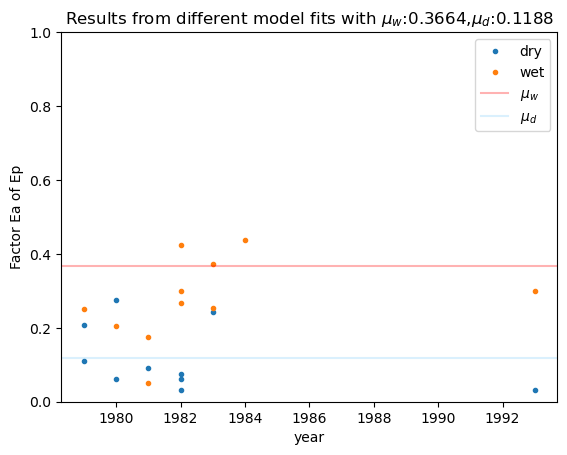

In [19]:
fig, ax = plt.subplots(1)
ax.plot(combined_factors["Year"].values,combined_factors["Factor_dry"].values,marker='.', lw=0,label="dry")
ax.plot(combined_factors["Year"].values,combined_factors["Factor_wet"].values,marker='.', lw=0,label="wet")

ax.set_ylim(0,1)
# median_factor = combined_factors["Factor"][combined_factors["Factor"]>0.2].median()
# ax.axhline(median_factor,color="g",alpha=0.3)

mean_factor_w = combined_factors["Factor_wet"][combined_factors["Factor_wet"]>0.0].mean()
ax.axhline(mean_factor_w,color="r",alpha=0.3,label="$\mu_w$")

mean_factor_d = combined_factors["Factor_dry"][combined_factors["Factor_dry"]>0].mean()
ax.axhline(mean_factor_d,color="lightskyblue",alpha=0.3,label="$\mu_d$")


ax.legend()
ax.set_xlabel("year")
ax.set_ylabel("Factor Ea of Ep")
ax.set_title(f"Results from different model fits with $\mu_w$:{mean_factor_w:.4f},$\mu_d$:{mean_factor_d:.4f}")